# 加利福尼亚房价预测

In [1]:
import torch
import pandas as pd
import numpy as np
from torch import nn
from d2l import torch as d2l

In [2]:
train_data= pd.read_csv("./california-house-prices/train.csv")
test_data= pd.read_csv("./california-house-prices/test.csv")

In [3]:
print(train_data.shape)
print(test_data.shape)

(47439, 41)
(31626, 40)


In [4]:
print(train_data.iloc[0:4, [0,1,2,3,4,-3,-2,-1]])
print("表头列名如下：")
print(train_data.columns)


   Id            Address  Sold Price  \
0   0        540 Pine Ln   3825000.0   
1   1     1727 W 67th St    505000.0   
2   2     28093 Pine Ave    140000.0   
3   3  10750 Braddock Dr   1775000.0   

                                             Summary          Type  \
0  540 Pine Ln, Los Altos, CA 94022 is a single f...  SingleFamily   
1  HURRY, HURRY.......Great house 3 bed and 2 bat...  SingleFamily   
2  'THE PERFECT CABIN TO FLIP!  Strawberry deligh...  SingleFamily   
3  Rare 2-story Gated 5 bedroom Modern Mediterran...  SingleFamily   

          City    Zip State  
0    Los Altos  94022    CA  
1  Los Angeles  90047    CA  
2   Strawberry  95375    CA  
3  Culver City  90230    CA  
表头列名如下：
Index(['Id', 'Address', 'Sold Price', 'Summary', 'Type', 'Year built',
       'Heating', 'Cooling', 'Parking', 'Lot', 'Bedrooms', 'Bathrooms',
       'Full bathrooms', 'Total interior livable area', 'Total spaces',
       'Garage spaces', 'Region', 'Elementary School',
       'Elementary S

In [5]:
all_features = pd.concat((train_data.drop(['Sold Price'], axis=1), test_data.iloc[:, 1:]))

In [6]:
print(all_features.iloc[0:4, [0,1,-2,-1]])

    Id            Address    Zip State
0  0.0        540 Pine Ln  94022    CA
1  1.0     1727 W 67th St  90047    CA
2  2.0     28093 Pine Ave  95375    CA
3  3.0  10750 Braddock Dr  90230    CA


In [7]:
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
numeric_features.shape,numeric_features.__class__

((19,), pandas.core.indexes.base.Index)

In [8]:
# 特殊处理 Bedrooms 列：将文本值转换为数字平均值
if 'Bedrooms' in all_features.columns:
    # 尝试转换为数字，无法转换的会变成 NaN
    bedrooms_numeric = pd.to_numeric(all_features['Bedrooms'], errors='coerce')
    
    # 计算纯数字值的平均值
    bedrooms_mean = bedrooms_numeric.mean()
    print(f"Bedrooms 列处理:")
    print(f"  - 纯数字值的平均值: {bedrooms_mean:.2f}")
    print(f"  - 包含文本的行数: {bedrooms_numeric.isna().sum()}")
    
    # 将 NaN（即原本的文本值）替换为平均值
    all_features['Bedrooms'] = bedrooms_numeric.fillna(bedrooms_mean)
    print(f"  - 处理后的 Bedrooms 列数据类型: {all_features['Bedrooms'].dtype}")
    print()

# 对数值特征进行标准化
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std())
)
all_features[numeric_features] = all_features[numeric_features].fillna(0)

Bedrooms 列处理:
  - 纯数字值的平均值: 3.06
  - 包含文本的行数: 12671
  - 处理后的 Bedrooms 列数据类型: float64



In [9]:
# 下面代码统计各学校类型（高中、初中、小学）出现次数最多的前10个名称及其出现次数
print("High School（高中）出现次数最多的前10个（包含出现次数）：")
print(all_features['High School'].value_counts().head(10))

print("Middle School（初中）出现次数最多的前10个（包含出现次数）：")
print(all_features['Middle School'].value_counts().head(10))

print("Elementary School（小学）出现次数最多的前10个（包含出现次数）：")
print(all_features['Elementary School'].value_counts().head(10))

print("Cooling（冷却系统）出现次数最多的前10个（包含出现次数）：")
print(all_features['Cooling'].value_counts().head(10))

print("Cooling features（冷却系统特征）出现次数最多的前10个（包含出现次数）：")
print(all_features['Cooling features'].value_counts().head(10))


High School（高中）出现次数最多的前10个（包含出现次数）：
High School
Fairfax Senior High School               1715
University Senior High School Charter    1417
Harbor High School                        948
Independence High School                  869
John Marshall Senior High School          694
Venice Senior High School                 657
Willow Glen High School                   626
Belmont Senior High School                618
Santa Clara High School                   607
Galileo High School                       596
Name: count, dtype: int64
Middle School（初中）出现次数最多的前10个（包含出现次数）：
Middle School
Hubert Howe Bancroft Middle School    1124
Mission Hill Middle School             796
Lick (James) Middle School             747
John Muir Middle School                721
Thomas Starr King Middle School        691
Willow Glen Middle School              626
Audubon Middle School                  617
John Burroughs Middle School           557
Paul Revere Middle School              485
Everett Middle School      

In [10]:
# 对 City 和 Region 进行特殊处理：只保留前10个最常见的值
print("\n对 City 和 Region 进行降维处理...")
for col in ['City', 'Region', 'High School', 'Middle School', 'Elementary School', 'Cooling', 'Cooling features']:
    if col in all_features.columns:
        # 获取前10个最常见的值
        top_15 = all_features[col].value_counts().head(15).index.tolist()
        print(f"\n{col} 前10个最常见值及其数量：")
        print(all_features[col].value_counts().head(15))
        
        # 将不在前10的值替换为 'Other'
        all_features[col] = all_features[col].apply(
            lambda x: x if x in top_15 else 'Other'
        )
        print(f"{col} 处理后的唯一值数量: {all_features[col].nunique()}")

# 删除不适合进行 one-hot 编码的高基数列
# 这些列如果进行 one-hot 编码会产生大量特征，导致维度爆炸
columns_to_drop = [
    'Address',              # 78875 个唯一值
    'Summary',              # 77773 个唯一值  
    'Appliances included',  # 11288 个唯一值
    'Parking',              # 9911 个唯一值
    'Parking features',     # 9693 个唯一值
    'Last Sold On',         # 6948 个唯一值（日期）
    'Elementary School',    # 3567 个唯一值
    'Laundry features',     # 3029 个唯一值
    'Listed On',            # 2815 个唯一值（日期）
    'Heating',              # 2658 个唯一值
    'Heating features',     # 1761 个唯一值
    'Flooring',             # 1738 个唯一值
]

print(f"\n删除 {len(columns_to_drop)} 个高基数列")
all_features = all_features.drop(columns=columns_to_drop)



对 City 和 Region 进行降维处理...

City 前10个最常见值及其数量：
City
Los Angeles      11918
San Jose          7030
San Francisco     5744
San Mateo         1125
San Diego         1108
Santa Clara       1099
Sunnyvale          872
Santa Cruz         866
Sacramento         839
Los Gatos          668
Redwood City       625
Morgan Hill        616
Compton            567
Gilroy             561
Mountain View      552
Name: count, dtype: int64
City 处理后的唯一值数量: 16

Region 前10个最常见值及其数量：
Region
Los Angeles      12273
San Jose          7298
San Francisco     5743
San Diego         1100
San Mateo          910
Sunnyvale          872
Santa Cruz         854
Santa Clara        839
Sacramento         834
Los Gatos          619
Morgan Hill        617
Gilroy             560
Compton            558
Mountain View      552
Redwood City       510
Name: count, dtype: int64
Region 处理后的唯一值数量: 16

High School 前10个最常见值及其数量：
High School
Fairfax Senior High School               1715
University Senior High School Charter    1417
Harbor

In [11]:
# 先检查每个列的唯一值数量
print("=" * 60)
print("每列的唯一值数量：")
print("=" * 60)
for col in all_features.columns:
    if all_features[col].dtype == 'object':  # 只检查分类特征
        unique_count = all_features[col].nunique()
        print(f"{col:20s}: {unique_count:6d} 个唯一值")
print("=" * 60)

每列的唯一值数量：
Type                :    174 个唯一值
Cooling             :     15 个唯一值
Region              :     16 个唯一值
Middle School       :     16 个唯一值
High School         :     16 个唯一值
Cooling features    :     15 个唯一值
City                :     16 个唯一值
State               :      2 个唯一值


In [12]:
# 进行 one-hot 编码（只对剩余的低基数分类特征）
all_features = pd.get_dummies(all_features, dummy_na=True)
print(f"\n预处理后的特征维度: {all_features.shape}")


预处理后的特征维度: (79065, 298)


In [13]:
# 确保所有列都是数值类型
# 有时 pd.get_dummies() 产生的列可能是 uint8，需要转换为 float
all_features = all_features.astype('float32')

# 再次检查是否有 NaN
if all_features.isna().any().any():
    print("警告：发现 NaN 值，正在填充...")
    all_features = all_features.fillna(0)

# 将 DataFrame 转换为 PyTorch tensor
n_train = train_data.shape[0]  # 训练集的样本数量

# 分割训练集和测试集
train_features = torch.tensor(all_features[:n_train].values, dtype=torch.float32)
test_features = torch.tensor(all_features[n_train:].values, dtype=torch.float32)

In [14]:
train_labels = torch.tensor(train_data['Sold Price'].values.reshape(-1, 1), dtype=torch.float32)

---

In [15]:
loss = nn.MSELoss()
in_features = train_features.shape[1]
print(in_features)

def get_net():
    net = nn.Sequential(
        nn.Linear(in_features, 128),
        nn.ReLU(),
        nn.Dropout(0.1),
        nn.Linear(128, 64),
        nn.ReLU(),
        nn.Dropout(0.1),
        nn.Linear(64, 1)
    )
    
    def init_weights(m):
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)  # 使用xavier初始化
            if m.bias is not None:
                nn.init.zeros_(m.bias)
    
    net.apply(init_weights)
    return net

298


In [16]:
def log_rmse(net, features, labels):
    # 为了在取对数时进一步稳定该值，将小于1的值设置为1
    clipped_preds = torch.clamp(net(features), 1, float('inf'))
    rmse = torch.sqrt(loss(torch.log(clipped_preds),
                           torch.log(labels)))
    return rmse.item()

In [17]:
def train(net, train_features, train_labels, test_features, test_labels, num_epochs, learning_rate, weight_decy, batch_size):
    train_ls, test_ls = [], []
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate, weight_decay=weight_decy)
    
    for epoch in range(num_epochs):
        net.train()
        for X, y in train_iter:
            optimizer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            optimizer.step()
        
        train_loss = log_rmse(net, train_features, train_labels)
        train_ls.append(train_loss)
        
        if test_labels is not None:
            val_loss = log_rmse(net, test_features, test_labels)
            test_ls.append(val_loss)
            
            # 每10个epoch打印一次
            if (epoch + 1) % 2 == 0:
                print(f'Epoch {epoch+1:3d}/{num_epochs}: Train Log RMSE: {train_loss:.4f}, Valid Log RMSE: {val_loss:.4f}')
        else:
            if (epoch + 1) % 2 == 0:
                print(f'Epoch {epoch+1:3d}/{num_epochs}: Train Log RMSE: {train_loss:.4f}')
    
    return train_ls, test_ls

In [18]:
num_epochs = 50
lr = 0.001
weight_decay = 0.01
batch_size = 64
net = get_net()

# 获取30%为验证数据集合
from sklearn.model_selection import train_test_split

# 打散数据集
from sklearn.utils import shuffle
train_features, train_labels = shuffle(train_features, train_labels, random_state=42)
train_features, valid_features, train_labels, valid_labels = train_test_split(
    train_features, train_labels, test_size=0.3, random_state=42
)
train_labels_log = torch.log(train_labels)
valid_labels_log = torch.log(valid_labels)

print(f"训练集样本数: {train_features.shape[0]}")
print(f"验证集样本数: {valid_features.shape[0]}")
print(f"特征维度: {train_features.shape[1]}")
print(f"开始训练...\n")

train_ls, test_ls = train(
    net, 
    train_features, train_labels_log,  # 改这里
    valid_features, valid_labels_log,  # 改这里
    num_epochs, lr, weight_decay, batch_size
)

训练集样本数: 33207
验证集样本数: 14232
特征维度: 298
开始训练...

Epoch   2/50: Train Log RMSE: 0.0794, Valid Log RMSE: 0.0799
Epoch   4/50: Train Log RMSE: 0.0746, Valid Log RMSE: 0.0756
Epoch   6/50: Train Log RMSE: 0.0712, Valid Log RMSE: 0.0703
Epoch   8/50: Train Log RMSE: 0.0704, Valid Log RMSE: 0.0696
Epoch  10/50: Train Log RMSE: 0.0668, Valid Log RMSE: 0.0664
Epoch  12/50: Train Log RMSE: 0.0670, Valid Log RMSE: 0.0673
Epoch  14/50: Train Log RMSE: 0.0611, Valid Log RMSE: 0.0617
Epoch  16/50: Train Log RMSE: 0.0661, Valid Log RMSE: 0.0661
Epoch  18/50: Train Log RMSE: 0.0583, Valid Log RMSE: 0.0577
Epoch  20/50: Train Log RMSE: 0.0559, Valid Log RMSE: 0.0559
Epoch  22/50: Train Log RMSE: 0.0541, Valid Log RMSE: 0.0543
Epoch  24/50: Train Log RMSE: 0.0525, Valid Log RMSE: 0.0520
Epoch  26/50: Train Log RMSE: 0.0523, Valid Log RMSE: 0.0567
Epoch  28/50: Train Log RMSE: 0.0483, Valid Log RMSE: 0.0489
Epoch  30/50: Train Log RMSE: 0.0503, Valid Log RMSE: 0.0502
Epoch  32/50: Train Log RMSE: 0.0453, 

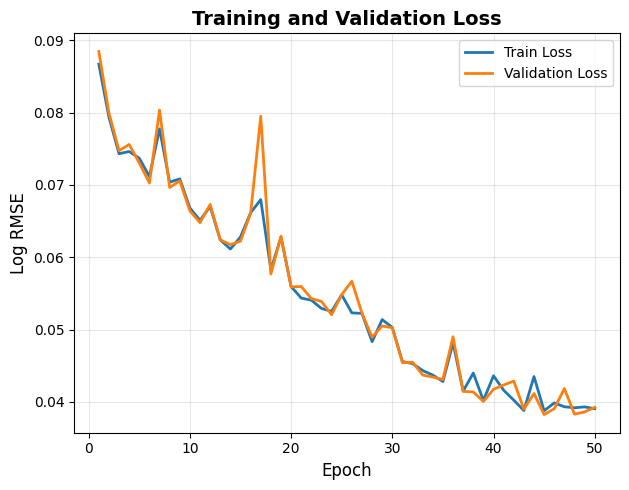


最终训练损失: 0.0390
最终验证损失: 0.0392
过拟合程度: 0.47%


In [19]:
# 绘制训练和验证损失曲线
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# 绘制损失曲线
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_ls, label='Train Loss', linewidth=2)
plt.plot(range(1, num_epochs + 1), test_ls, label='Validation Loss', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Log RMSE', fontsize=12)
plt.title('Training and Validation Loss', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

# 绘制后50个epoch的损失曲线（放大显示后期变化）
if num_epochs > 50:
    plt.subplot(1, 2, 2)
    start_epoch = num_epochs - 50
    plt.plot(range(start_epoch + 1, num_epochs + 1), train_ls[start_epoch:], label='Train Loss', linewidth=2)
    plt.plot(range(start_epoch + 1, num_epochs + 1), test_ls[start_epoch:], label='Validation Loss', linewidth=2)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Log RMSE', fontsize=12)
    plt.title('Last 50 Epochs (Zoomed)', fontsize=14, fontweight='bold')
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n最终训练损失: {train_ls[-1]:.4f}")
print(f"最终验证损失: {test_ls[-1]:.4f}")
print(f"过拟合程度: {(test_ls[-1] - train_ls[-1]) / train_ls[-1] * 100:.2f}%")


In [20]:
def predict(net, test_features, test_data):
    net.eval()
    with torch.no_grad():
        preds_log = net(test_features).detach().numpy()
        # 从log空间转回原始空间
        preds = np.exp(preds_log)
    
    submission = pd.DataFrame({
        'Id': test_data['Id'],
        'Sold Price': preds.reshape(-1)
    })
    submission.to_csv('submission.csv', index=False)
    return submission

submission = predict(net, test_features, test_data)
submission.head(10)

,Id,Sold Price
0,47439,9.240309e+05
1,47440,4.709776e+05
2,47441,9.657080e+05
3,47442,8.989541e+05
4,47443,1.048738e+06
5,47444,7.355769e+05
6,47445,1.504420e+06
7,47446,3.645640e+05
8,47447,2.251419e+06
9,47448,4.345508e+05
